Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import imageio
from IPython.display import Image
import warnings
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)
warnings.filterwarnings('ignore')

# Datasets

In [3]:
df_hans = pd.read_csv('../data/interim/hans_pre_covid.csv')

In [4]:
df_hans.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N,ANO_REF
0,21.0,210632,1438.0,2455552.0,27/09/1995,1955.0,F,5.0,2.0,0.0,21.0,210632.0,1438.0,999993.0,4.0,1.0,2.0,2.0,1.0,20/09/2011,2.0,MA,210632.0,06/06/2005,2455552.0,21.0,210632.0,2.0,1.0,2.0,NaN,2005,3.0,7.0,3.0,7.0,01/10/2012,1.0,2011
1,21.0,210860,1435.0,2817993.0,22/09/2006,NaN,M,6.0,4.0,6.0,21.0,210860.0,1435.0,999991.0,1.0,NaN,1.0,1.0,NaN,22/09/2009,1.0,MA,210860.0,22/09/2006,2817993.0,21.0,210860.0,1.0,NaN,1.0,NaN,2006,NaN,4.0,NaN,NaN,23/05/2012,7.0,2009
2,29.0,291560,1388.0,5504120.0,15/10/2006,1963.0,M,6.0,4.0,2.0,29.0,291560.0,1388.0,NaN,4.0,0.0,2.0,1.0,1.0,15/10/2009,2.0,BA,291560.0,15/10/2006,5504120.0,NaN,NaN,2.0,NaN,2.0,4.0,2006,10.0,3.0,12.0,2.0,06/12/2010,1.0,2009
3,41.0,410830,1363.0,2673177.0,30/03/2007,1970.0,F,5.0,4.0,1.0,41.0,410830.0,1363.0,999992.0,3.0,0.0,2.0,1.0,NaN,19/10/2009,2.0,PR,410830.0,30/03/2007,2673177.0,41.0,410830.0,2.0,NaN,2.0,4.0,2007,6.0,5.0,1.0,1.0,11/11/2010,7.0,2009
4,33.0,330250,NaN,2278634.0,28/07/2007,1935.0,F,9.0,4.0,9.0,33.0,330250.0,NaN,NaN,2.0,1.0,2.0,1.0,3.0,28/07/2009,2.0,RJ,330250.0,28/07/2007,2278634.0,33.0,330250.0,2.0,1.0,2.0,4.0,2007,2.0,0.0,12.0,0.0,07/07/2010,1.0,2009


In [5]:
df_hans.shape

(309292, 39)

In [6]:
# Remove datas inconsistentes

try:
  df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'])
  df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'])
except ValueError:
    df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'], errors='coerce')
    df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'], errors='coerce')

df_hans['DURACAO_TRAT'] = (df_hans['DTALTA_N'] - df_hans['DTINICTRAT']).dt.days
df_hans = df_hans[df_hans['DURACAO_TRAT'] >= 0]

# EDA

### Análise de casos por estado

In [7]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'index': 'UF', 'UFATUAL': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,35232
1,PA,29656
2,MT,29466
3,PE,24451
4,BA,22771


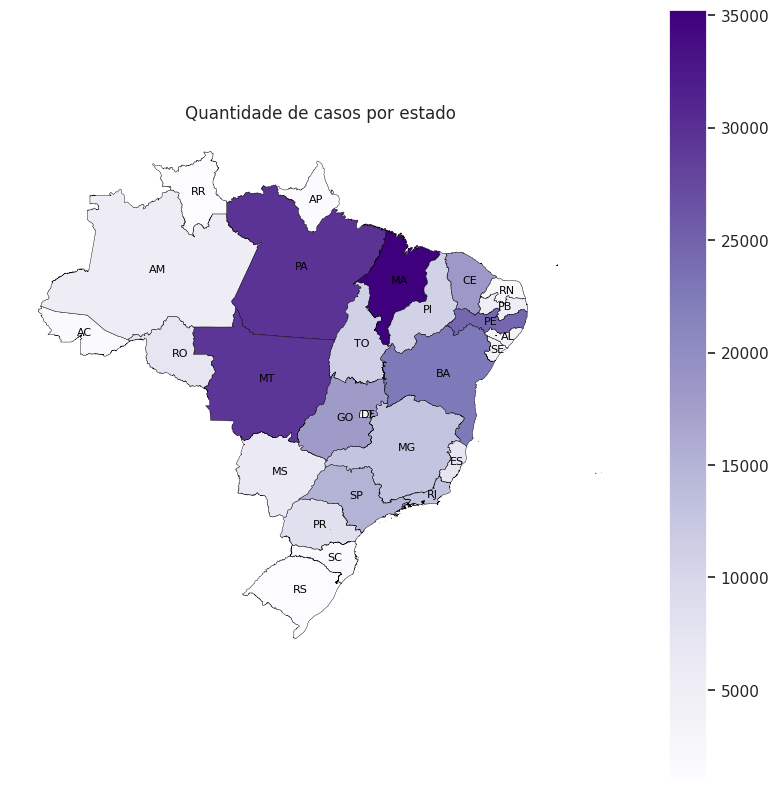

In [8]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e por ano

In [12]:
df_uf_pop = pd.read_csv("../data/raw/data_uf_pop_year.csv")
df_hans_states_per_year = df_hans[['UFATUAL', 'ANO_REF']].value_counts().to_frame().reset_index()
df_hans_states_per_year = df_hans_states_per_year.rename(columns={'UFATUAL': 'UF', 0: 'Contagem'})
df_hans_states_per_year = pd.merge(df_hans_states_per_year, df_uf_pop[['UF','ANO_REF', 'POP']],on=['UF','ANO_REF'], how='left')
df_hans_states_per_year["Contagem_por_100k"] = df_hans_states_per_year["Contagem"] / df_hans_states_per_year["POP"] * 100000
df_hans_states_per_year.head()

,UF,ANO_REF,Contagem,POP,Contagem_por_100k
0,MT,2018,4043,3441998,117.460847
1,MT,2019,3841,3484466,110.232099
2,MA,2009,3683,6639032,55.474955
3,MA,2010,3606,6710964,53.732966
4,PA,2009,3548,7637004,46.458009


In [13]:
years_analysis = df_hans_states_per_year['ANO_REF'].unique()
years_analysis.sort()

vmax=df_hans_states_per_year['Contagem_por_100k'].max()

In [14]:
for i in range(len(years_analysis)):
    year = years_analysis[i]
    # Combina o DataFrame com o GeoDataFrame do mapa
    map_occurrences = map.merge(df_hans_states_per_year[df_hans_states_per_year['ANO_REF']==year], left_on='SIGLA_UF', right_on='UF')
    map_occurrences.drop(['ANO_REF'], axis=1, inplace=True)
    map_occurrences.fillna(0, inplace=True)

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(column='Contagem_por_100k', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, vmin=0, vmax=vmax)

    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    ax.set_title('Quantidade de casos a cada 100 mil hab. por estado em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_por_100k_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for i in range(len(years_analysis)):
    year = years_analysis[i]
    nome_arquivo = f'../assets/graficos/mapa_por_100k_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_por_100k.gif', imagens, duration=500)

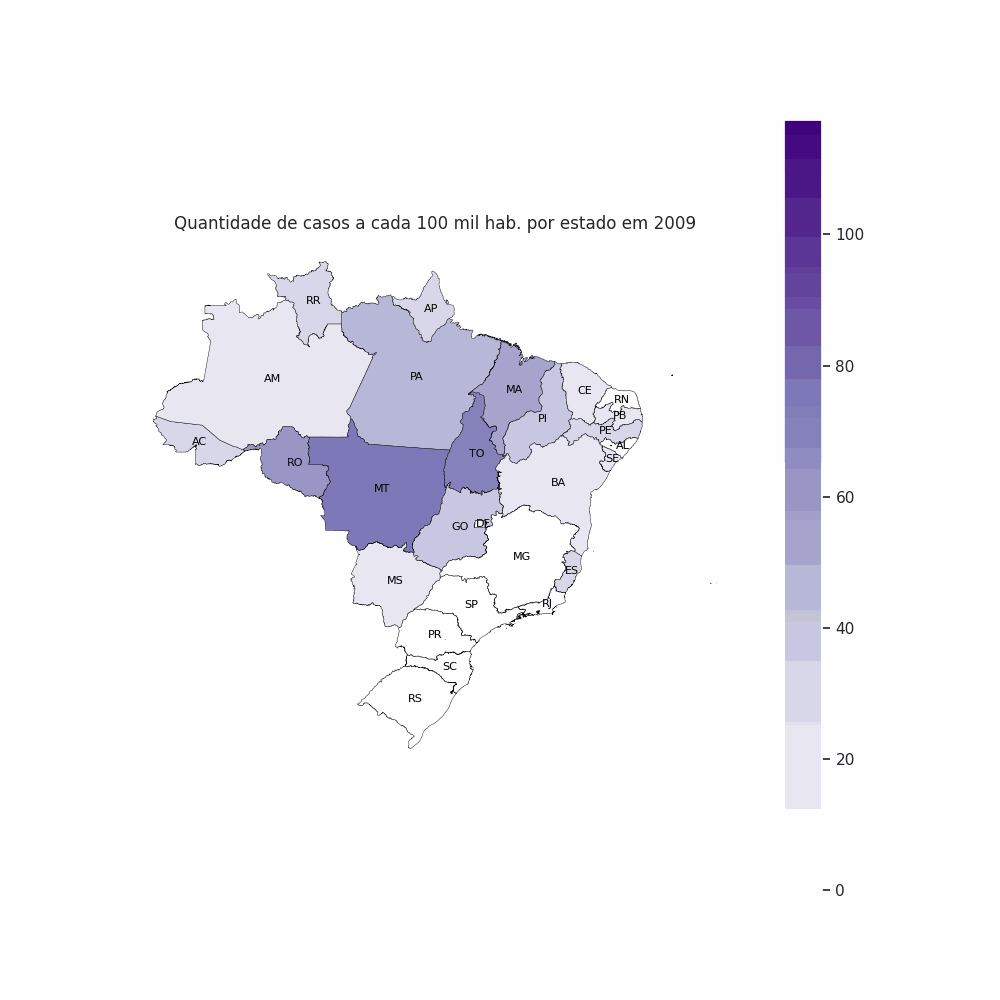

In [15]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_por_100k.gif')


### Correlação da quantidade de casos e o IDH dos estados

#### 1. Sem remover outliers

In [13]:
df_idh = pd.read_csv('../data/interim/idh_interim.csv')
df_idh['IDH'] = df_idh['IDH'].astype(float)
df_idh.head()

,UF,ANO_REF,IDH
0,AC,2009,0.663
1,AL,2009,0.631
2,AP,2009,0.708
3,AM,2009,0.674
4,BA,2009,0.660


In [14]:
df_hans_idh = pd.merge(df_hans_states_per_year, df_idh, on=['UF', 'ANO_REF'], how='inner')
df_hans_idh.head()

,UF,ANO_REF,Contagem,IDH
0,MT,2018,4043,0.778
1,MT,2019,3841,0.779
2,MA,2009,3683,0.639
3,MA,2010,3606,0.639
4,PA,2009,3548,0.646


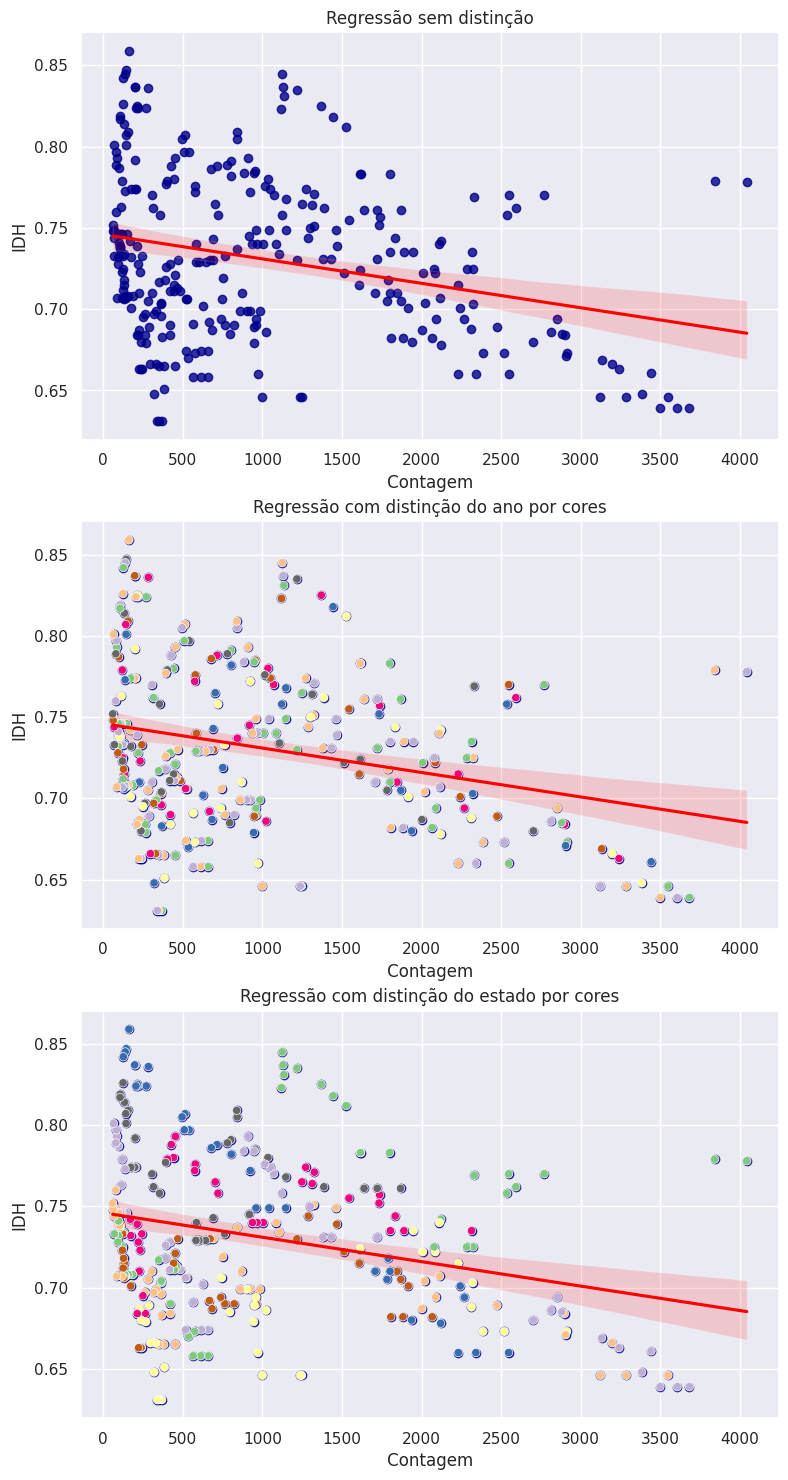

In [15]:
# Cria o gráfico de dispersão com linha de regressão
fig, axes = plt.subplots(3,1, figsize=(9, 18))
sns.regplot(x='Contagem', y='IDH', data=df_hans_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[0])
sns.regplot(x='Contagem', y='IDH', data=df_hans_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[1])
sns.regplot(x='Contagem', y='IDH', data=df_hans_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[2])
sns.scatterplot(x='Contagem', y='IDH', data=df_hans_idh, hue="ANO_REF", palette='Accent', ax=axes[1], legend=False)
sns.scatterplot(x='Contagem', y='IDH', data=df_hans_idh, hue="UF", palette='Accent', ax=axes[2], legend=False)

axes[0].set_title("Regressão sem distinção")
axes[1].set_title("Regressão com distinção do ano por cores")
axes[2].set_title("Regressão com distinção do estado por cores")

# Exibe o gráfico
plt.show()

In [16]:
# Calcule a correlação entre as variáveis
correlation = df_hans_idh['Contagem'].corr(df_hans_idh['IDH'])
# Imprima o resultado
print('Correlação:', correlation)

# Calcule a covariância entre as variáveis
covariance = df_hans_idh['Contagem'].cov(df_hans_idh['IDH'])
# Imprima o resultado
print('Covariância:', covariance)


Correlação: -0.27403391921820963
Covariância: -12.795052211302211


### Análise de casos por estado e gravidade

In [17]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,1309
1,AC,1.0,285
2,AC,2.0,92
3,AC,3.0,20
4,AL,0.0,1888


#### Grau 0:

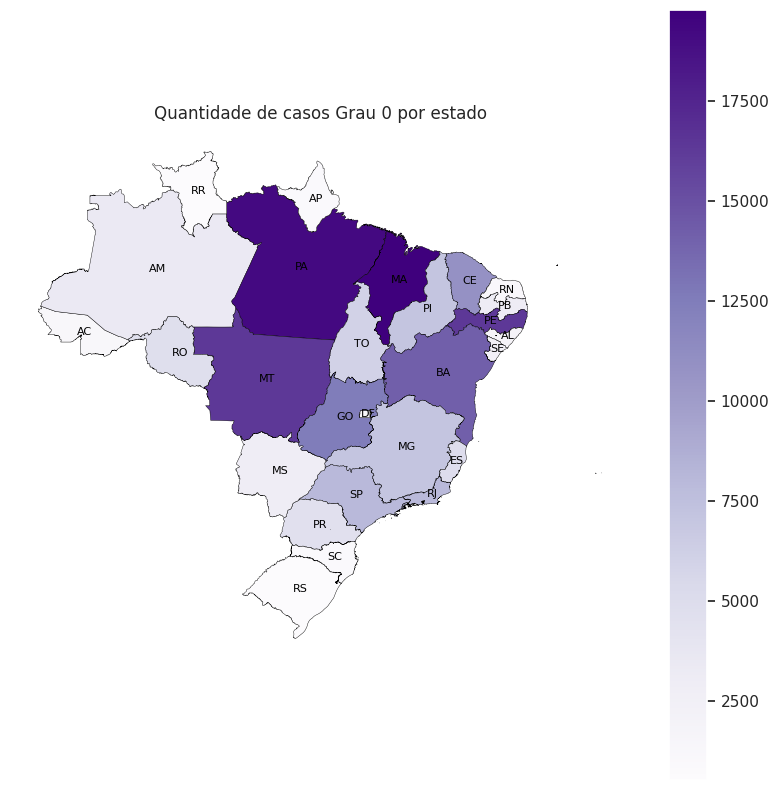

In [18]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

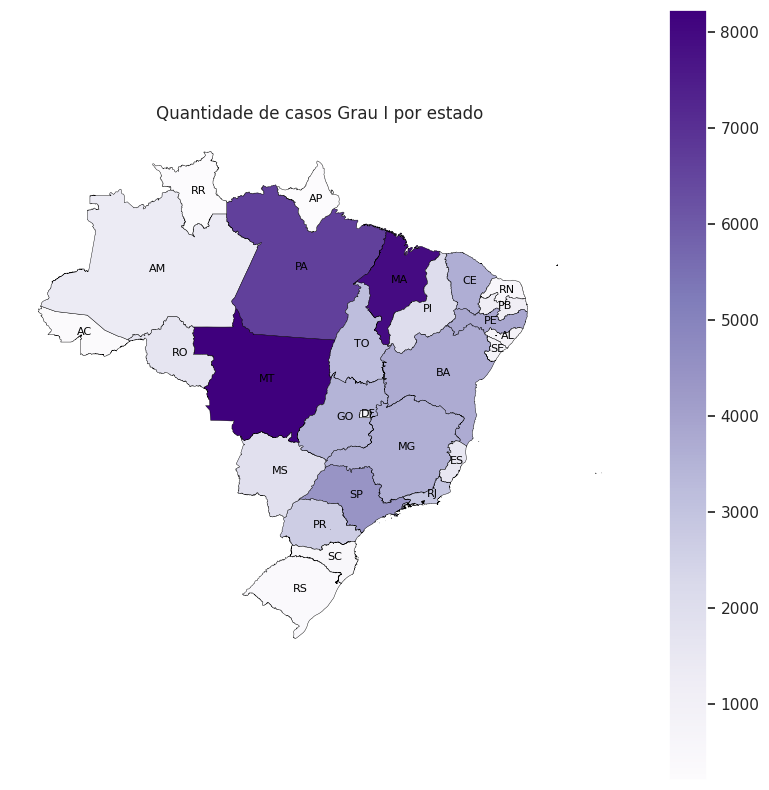

In [19]:

df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

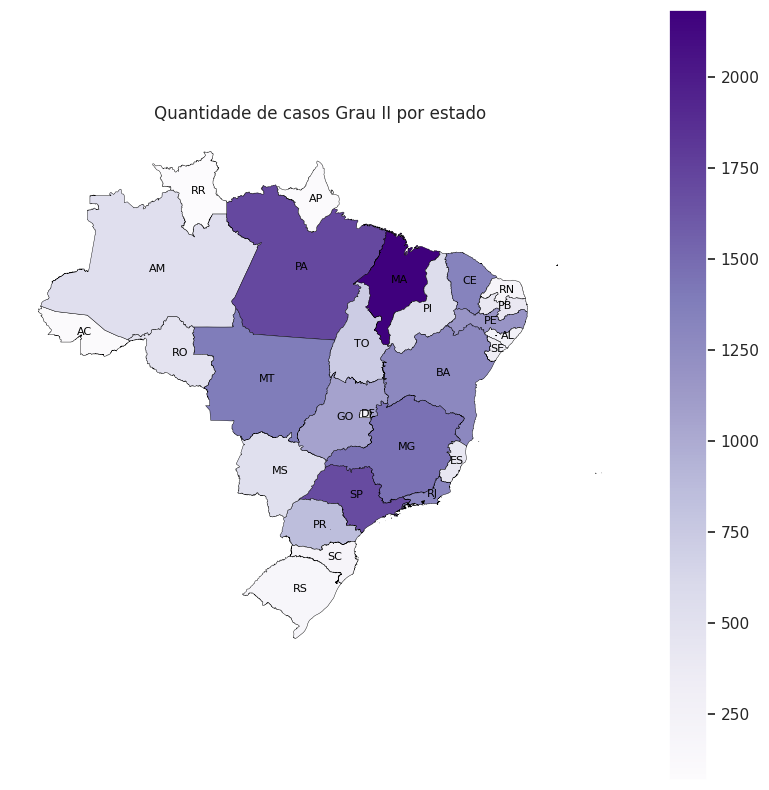

In [20]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()

### Análise do abandono

In [21]:
# Considerar apenas casos com desfecho: cura, óbito ou abandono
df_hans_tp_alta = df_hans[df_hans['TPALTA_N'].isin([1, 6, 7])]

<Axes: >

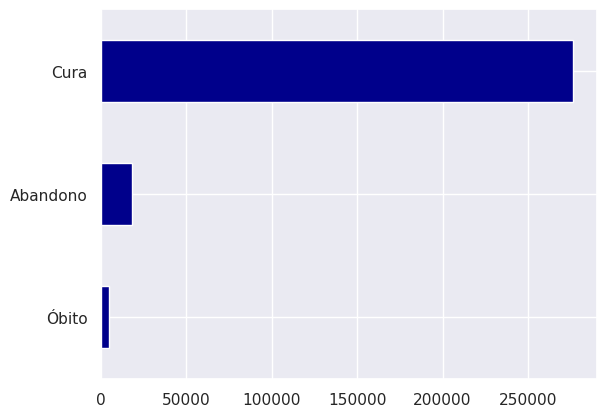

In [22]:
df_hans_outcome = df_hans_tp_alta.copy()
df_hans_outcome['TPALTA_N'] = df_hans_outcome['TPALTA_N'].replace({1: 'Cura', 6: 'Óbito', 7: 'Abandono'})
df_hans_outcome['TPALTA_N'].value_counts().sort_values().plot.barh(color='darkblue')

In [23]:
# Agrupa os dados pelo ano e pelo munícipio da ultima atualização
gp_muni_at = df_hans.groupby(["ANO_REF", "ID_MUNI_AT"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_muni_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_muni_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
ANO_REF ID_MUNI_AT                                
2009    110001.0         36          0    0.000000
        110002.0         74          0    0.000000
        110003.0          1          0    0.000000
        110004.0         39          3    0.076923
        110005.0          8          2    0.250000
...                     ...        ...         ...
2019    522160.0         11          1    0.090909
        522170.0          2          0    0.000000
        522180.0          1          0    0.000000
        522205.0          5          1    0.200000
        530010.0        162         22    0.135802

[29967 rows x 3 columns]

In [24]:
# Leitura dos polígonos das cidades brasileiras de uma cópia local
geo = gpd.read_file("../assets/mapa/all_cities.shp")
# Adapta o código das cidades do ibge para a versão utilizada pelo ministério da saúde 
geo["muni"] = geo["code_muni"].astype("string").str.slice(stop=-3).astype("float64")

for year in years_analysis:
    # Combina as contagens de abandono por cidade com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["muni"], right_on=["ID_MUNI_AT"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.1, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6}
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab.gif', imagens, duration=500)

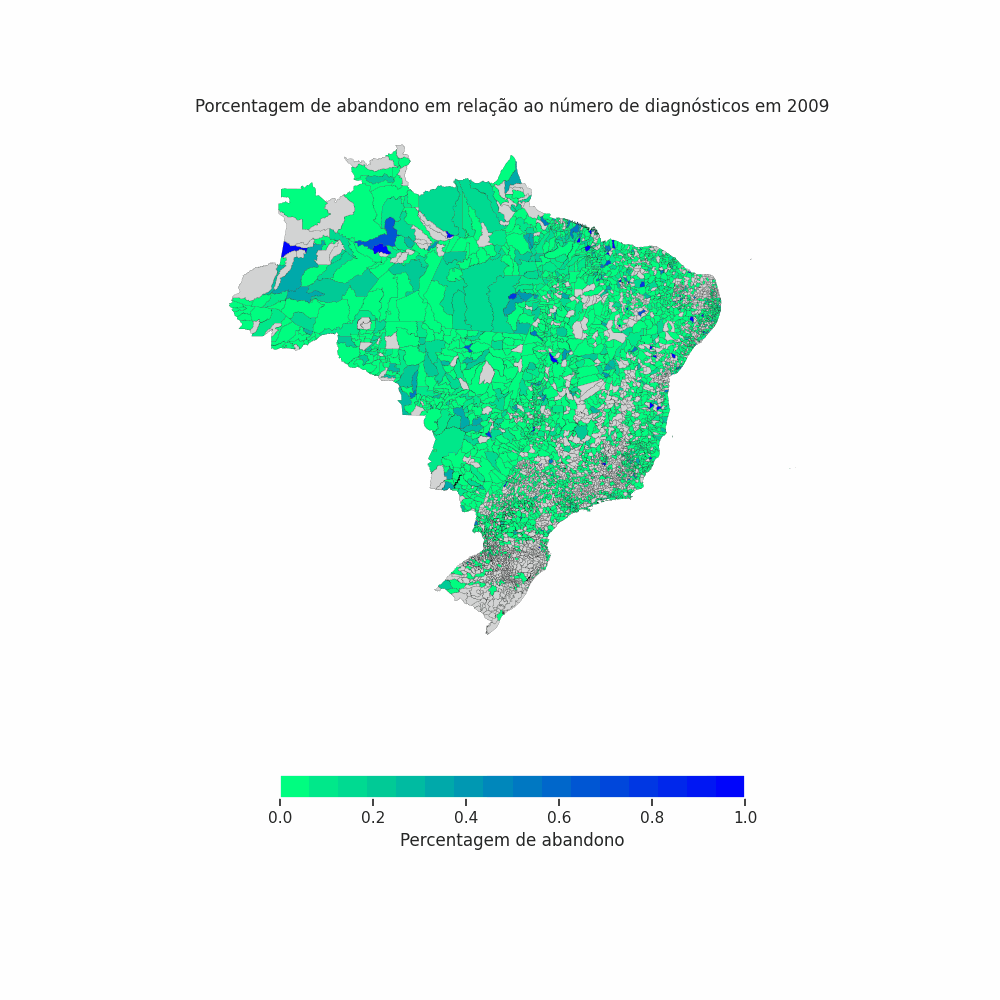

In [25]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab.gif')

In [26]:
# Agrupar abandonos por estado
gp_uf_at = df_hans.groupby(["ANO_REF", "UFATUAL"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_uf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_uf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
ANO_REF UFATUAL                                
2009    AC           242          3    0.012397
        AL           368         25    0.067935
        AM           659         54    0.081942
        AP           186         31    0.166667
        BA          2547        163    0.063997
...                  ...        ...         ...
2019    RS            65          5    0.076923
        SC           125          7    0.056000
        SE           283         10    0.035336
        SP          1125         80    0.071111
        TO          1323         96    0.072562

[297 rows x 3 columns]

In [27]:
# Leitura dos polígonos dos estados brasileiros de uma cópia local
geo = gpd.read_file("../assets/mapa/BR_UF_2022.shp")

# Max e Min dos valores
vmin = min(count_df["PERCENT_AB"])
vmax = max(count_df["PERCENT_AB"])

for year in years_analysis:    
    # Combina as contagens de abandono por estado com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["SIGLA_UF"], right_on=["UFATUAL"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6},
        vmin=vmin, vmax=vmax
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_uf_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_uf_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab_uf.gif', imagens, duration=500)

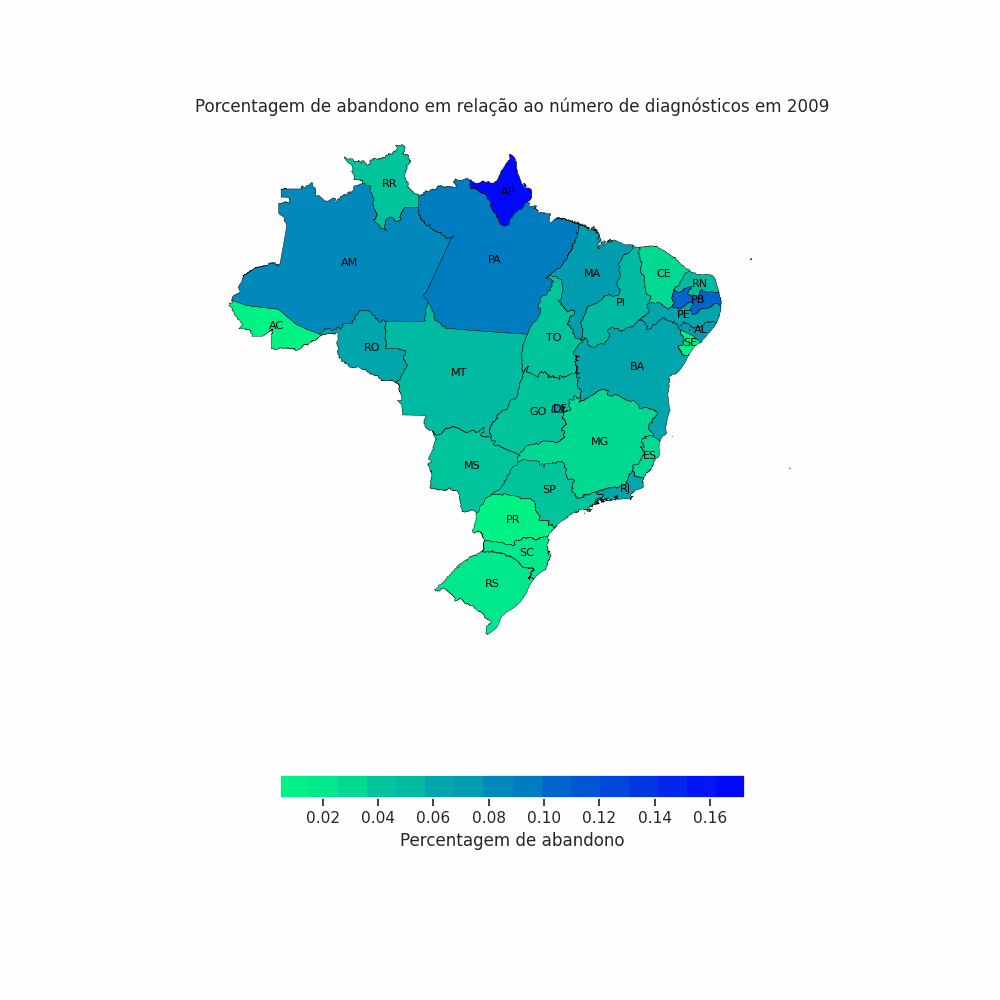

In [28]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab_uf.gif')

In [29]:
df_hans_ab_idh = pd.merge(count_df.reset_index(), df_idh, right_on=['UF', 'ANO_REF'], left_on=['UFATUAL', 'ANO_REF'], how='inner')
df_hans_ab_idh.head()

,ANO_REF,UFATUAL,DT_DIAG,ABANDONOS,PERCENT_AB,UF,IDH
0,2009,AC,242,3,0.012397,AC,0.663
1,2009,AL,368,25,0.067935,AL,0.631
2,2009,AM,659,54,0.081942,AM,0.674
3,2009,AP,186,31,0.166667,AP,0.708
4,2009,BA,2547,163,0.063997,BA,0.660


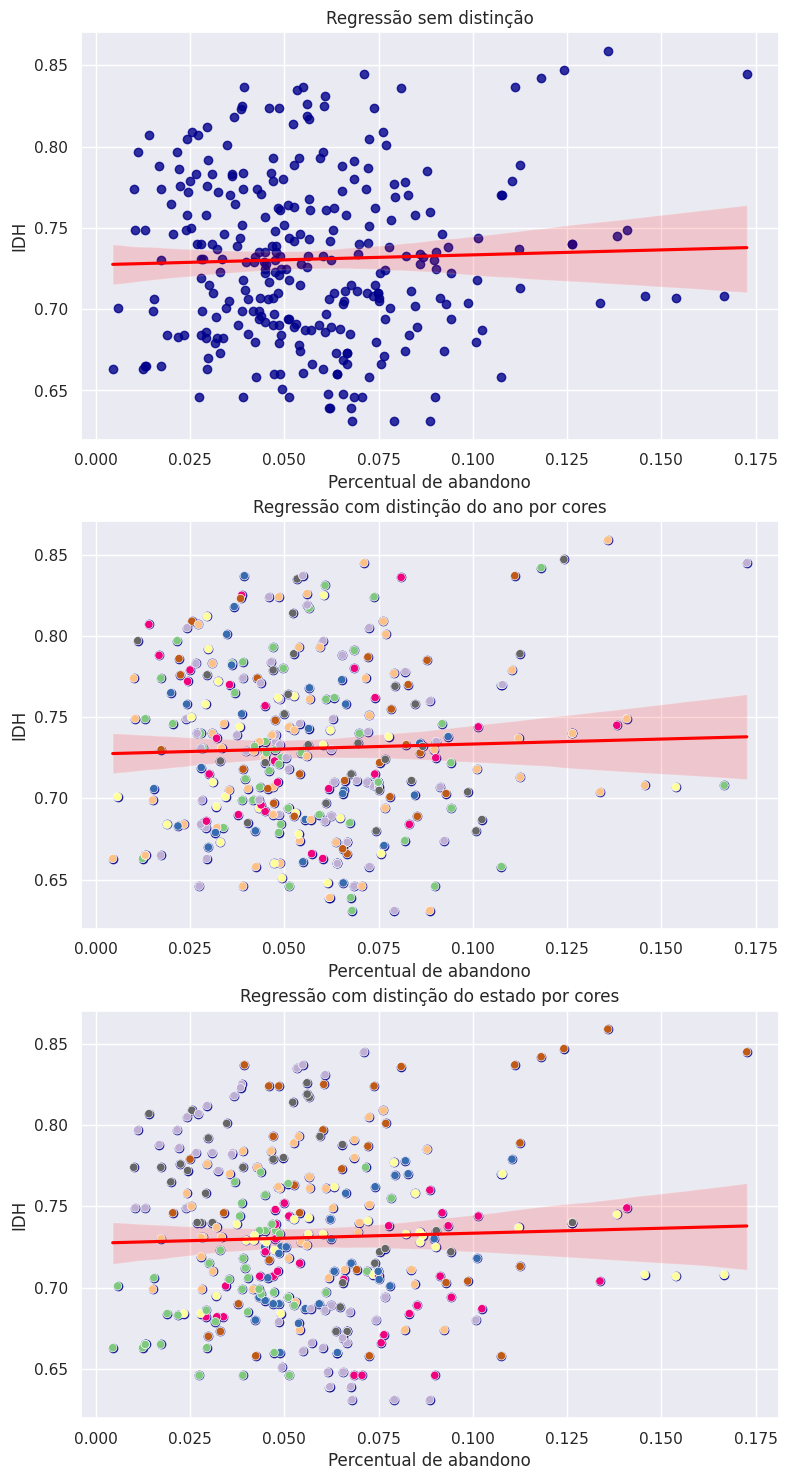

In [30]:
# Cria o gráfico de dispersão com linha de regressão
fig, axes = plt.subplots(3,1, figsize=(9, 18))
sns.regplot(x='PERCENT_AB', y='IDH', data=df_hans_ab_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[0])
sns.regplot(x='PERCENT_AB', y='IDH', data=df_hans_ab_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[1])
sns.regplot(x='PERCENT_AB', y='IDH', data=df_hans_ab_idh, color='darkblue', line_kws={'color': 'red'}, ax=axes[2])
sns.scatterplot(x='PERCENT_AB', y='IDH', data=df_hans_ab_idh, hue="ANO_REF", palette='Accent', ax=axes[1], legend=False)
sns.scatterplot(x='PERCENT_AB', y='IDH', data=df_hans_ab_idh, hue="UF", palette='Accent', ax=axes[2], legend=False)

axes[0].set_title("Regressão sem distinção")
axes[1].set_title("Regressão com distinção do ano por cores")
axes[2].set_title("Regressão com distinção do estado por cores")
axes[0].set_xlabel("Percentual de abandono")
axes[1].set_xlabel("Percentual de abandono")
axes[2].set_xlabel("Percentual de abandono")


# Exibe o gráfico
plt.show()

In [31]:
# Calcule a correlação entre as variáveis
correlation = df_hans_ab_idh['PERCENT_AB'].corr(df_hans_idh['IDH'])
# Imprima o resultado
print('Correlação:', correlation)

# Calcule a covariância entre as variáveis
covariance = df_hans_ab_idh['PERCENT_AB'].cov(df_hans_idh['IDH'])
# Imprima o resultado
print('Covariância:', covariance)

Correlação: 0.09167780930966034
Covariância: 0.00013338937956609788


In [32]:
# Agrupar abandonos por sexo
gp_mf_at = df_hans.groupby(["ANO_REF", "CS_SEXO"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_mf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_mf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df = count_df.drop('I', level='CS_SEXO')
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
ANO_REF CS_SEXO                                
2009    F          15283        793    5.188772
        M          18948       1112    5.868693
2010    F          13606        647    4.755255
        M          17238        883    5.122404
2011    F          13335        651    4.881890
        M          16954        785    4.630176
2012    F          12712        581    4.570485
        M          16526        888    5.373351
2013    F          12524        643    5.134142
        M          15436        836    5.415911
2014    F          12499        732    5.856469
        M          15240        891    5.846457
2015    F          11081        784    7.075174
        M          14171        915    6.456848
2016    F           9765        630    6.451613
        M          12219        855    6.997299
2017    F          10160        745    7.332677
        M          12740        852    6.687598
2018    F          11331        741    6.539582
        M          13483        931    6.904991
2019    F          10848        916    8.443953
        M          13278       1202    9.052568

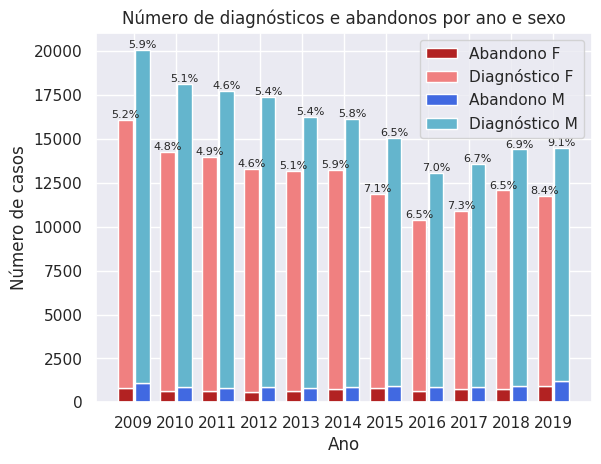

In [33]:
years = count_df.index.get_level_values('ANO_REF').unique()
sexes = count_df.index.get_level_values('CS_SEXO').unique()

bar_width = 0.35
r = np.arange(len(years))
spacing = [0.15-bar_width, -0.15+bar_width]
colors = [['lightcoral', 'firebrick'], ['c', 'royalblue']]
legend_handles = list()

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        aband_bar = plt.bar(r[i] + spacing[j], 
                            count_df['ABANDONOS'].loc[year, sex], 
                            width=bar_width, color=colors[j][1],
                            label=f"Abandonos {sex}")
        legend_handles.append(aband_bar[0])
        
        diag_bar = plt.bar(r[i] + spacing[j], 
                           count_df['DT_DIAG'].loc[year, sex], 
                           width=bar_width, color=colors[j][0], 
                           label=f"Diagnóstico {sex}",
                           bottom=count_df['ABANDONOS'].loc[year, sex])
        legend_handles.append(diag_bar[0])
        
        total = count_df['ABANDONOS'].loc[year, sex] + count_df['DT_DIAG'].loc[year, sex]
        plt.text(r[i] + spacing[j], total, 
                 f'{count_df["PERCENT_AB"].loc[year,sex]:.1f}%', 
                 ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Ano")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por ano e sexo")

plt.xticks(r, years)
plt.legend(handles=legend_handles, labels=['Abandono F',
                                           'Diagnóstico F',
                                           'Abandono M',
                                           'Diagnóstico M'])
plt.savefig('../assets/graficos/graficos_ab_sexo.png')
plt.show()

In [34]:
df_hans['IDADE'] = df_hans['ANO_REF'] - df_hans['ANO_NASC']
df_hans['FAIXA_ETARIA'] = np.round(df_hans['IDADE']/10)*10
gp_idade = df_hans.groupby(["FAIXA_ETARIA"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_idade['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_idade['DT_DIAG'].count()

count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df

,DT_DIAG,ABANDONOS,PERCENT_AB
FAIXA_ETARIA,,,
0.0,1119,45,4.021448
10.0,17585,795,4.520898
20.0,32669,3223,9.865622
30.0,41404,3354,8.100667
40.0,58147,3803,6.540320
50.0,50848,2558,5.030680
60.0,53256,2303,4.324395
70.0,26089,1036,3.971022
80.0,13186,566,4.292431


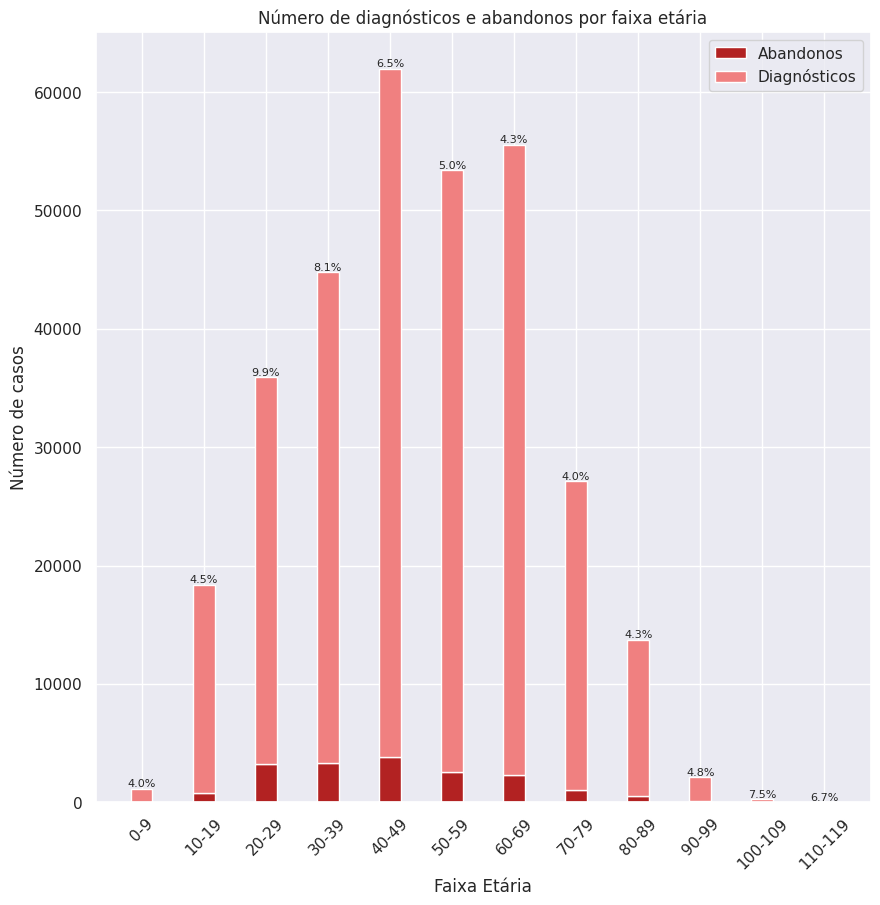

In [35]:
years = count_df.index.get_level_values('FAIXA_ETARIA').unique()[:-1]

bar_width = 0.35
r = np.arange(len(years))
colors = ['lightcoral', 'firebrick']
legend_handles = list()

plt.figure(figsize=(10,10))
for i, year in enumerate(years):
    aband_bar = plt.bar(r[i], 
                        count_df['ABANDONOS'].loc[year], 
                        width=bar_width, color=colors[1],
                        label="Abandonos")
    legend_handles.append(aband_bar[0])
    
    diag_bar = plt.bar(r[i],
                       count_df['DT_DIAG'].loc[year], 
                       width=bar_width, color=colors[0], 
                       label="Diagnósticos",
                       bottom=count_df['ABANDONOS'].loc[year])
    legend_handles.append(diag_bar[0])
    
    total = count_df['ABANDONOS'].loc[year] + count_df['DT_DIAG'].loc[year]
    plt.text(r[i], total, 
             f'{count_df["PERCENT_AB"].loc[year]:.1f}%', 
             ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Faixa Etária")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por faixa etária")
plt.xticks(r, ['0-9', '10-19', '20-29', '30-39', '40-49',
            '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119'])
plt.xticks(rotation=45)

plt.legend(handles=legend_handles, labels=['Abandonos',
                                           'Diagnósticos'])
plt.savefig('../assets/graficos/graficos_ab_idade.png')
plt.show()

### Correlação variáveis

#### Tempo de Cura

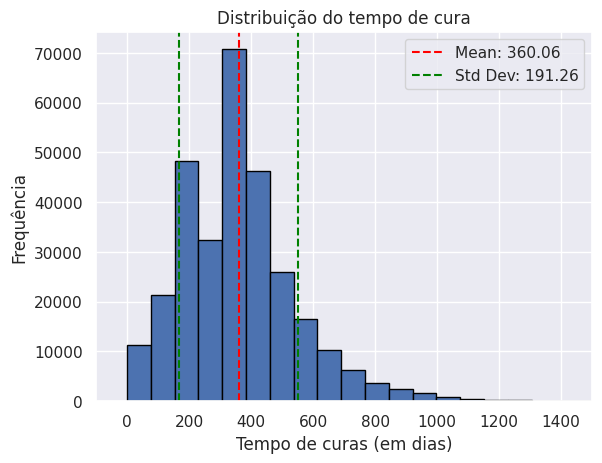

In [36]:
# Análise da distribuição dos tempos de cura
column_name = 'DURACAO_TRAT'
filtered_data = df_hans[df_hans[column_name] >= 0][column_name]

mean = np.mean(filtered_data)
std_dev = np.std(filtered_data)


plt.hist(filtered_data, bins=50, edgecolor='black')
plt.xlabel('Tempo de curas (em dias)')
plt.ylabel('Frequência')
plt.title('Distribuição do tempo de cura')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1.5, label=f'Std Dev: {std_dev:.2f}')
plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1.5)
plt.legend()

x_min = -100 
x_max = 1500
plt.xlim(x_min, x_max)

plt.show()

In [37]:
column_name = 'DURACAO_TRAT' 
correlation = df_hans.corr()[column_name] 
print(correlation)

SG_UF_NOT       0.049387
ID_MUNICIP      0.049532
ID_REGIONA      0.005332
ID_UNIDADE      0.007984
ANO_NASC       -0.019849
CS_GESTANT      0.014816
CS_RACA        -0.000122
SG_UF           0.049796
ID_MN_RESI      0.049930
ID_RG_RESI      0.005723
FORMACLINI      0.290824
AVALIA_N        0.112460
CLASSOPERA      0.385266
MODODETECT     -0.002717
BACILOSCOP     -0.066873
ESQ_INI_N       0.389906
ID_MUNI_AT      0.049505
ID_UNID_AT      0.009161
UFRESAT         0.049495
MUNIRESAT       0.049684
CLASSATUAL      0.400121
AVAL_ATU_N      0.110261
ESQ_ATU_N       0.411811
EPIS_RACIO     -0.109998
NU_ANO          0.060087
NU_LESOES       0.153296
CONTREG         0.010999
DOSE_RECEB      0.458069
CONTEXAM        0.012708
TPALTA_N        0.058874
ANO_REF         0.058054
DURACAO_TRAT    1.000000
IDADE           0.029942
FAIXA_ETARIA    0.029299
Name: DURACAO_TRAT, dtype: float64


#####
Note que as correlações mais altas se dão, em ordem decrescente, com as colunas:

CLASSOPERA (0.461423) - classificação operacional, virável categórica para 1 = paucibacilar, 2 = multibacilar

FORMACLINI (0.366289) - forma clínica da doença, variável categórica para 1 = indeterminada, 2 = tuberculóide, 3 = dimorfa, 4 = virchowiana, 5 = não classficado

NU_LESOES (0.210927) - número de lesões

#### Tipo de Saída

In [38]:
df_hans_outcome = df_hans_outcome[df_hans_outcome['TPALTA_N'] != 'Óbito']

In [39]:
target = 'TPALTA_N'
num_feats = [col for col in df_hans_outcome.columns if ((df_hans_outcome[col].dtype != 'O') & (df_hans_outcome[col].dtype != 'datetime64[ns]'))]
cat_feats = [col for col in df_hans_outcome.columns if col not in num_feats and col != 'CG']

In [40]:
def cut_cat_features(df, feature, top_n=10, only_top=True, vc_th=5):
    
    vc = df[feature].value_counts()
    vc = vc[vc > vc_th]
    if not only_top:
        return list(vc.index)
    return list(vc.head(top_n).index)

def boxplot_num_cat(df, num_col, cat_col, ax):
    
    df_plot = df[(df[num_col].notna())].copy()
    sns.boxplot(ax=ax, x=cat_col, y=num_col, data=df_plot, showfliers=False)
    
def boxplot_cat_num(df, cat_col, num_col, ax):
    
    df_plot = df[(df[num_col].notna())&\
                 (df[num_col] > 0)].copy()
    top_classes = cut_cat_features(df_plot, cat_col, vc_th=1)
    df_plot = df_plot[df_plot[cat_col].isin(top_classes)]
    sns.boxplot(ax=ax, x=num_col, y=cat_col, data=df_plot, showfliers=False)
    
def stacked_bar_plot(df, feature, target, ax):
    
    df_plot = df.copy()
    top_classes = cut_cat_features(df_plot, feature)
    df_plot = df_plot[df_plot[feature].isin(top_classes)]
    pd.pivot_table(
        df_plot.groupby(feature)[target].value_counts(1).reset_index(level=0).rename(columns={target:'prop'}).reset_index(), 
        values='prop', columns=target, index=feature).plot(kind='barh', stacked=True, legend=False, ax=ax)
    
def scatter_plot(df, feature_col, target_col, ax):
    
    df_plot = df[(df[feature_col].notna())&(df[target_col].notna())&(df[target_col] > 0)]
    sns.scatterplot(x=feature_col, y=target_col, data=df, ax=ax)
        
def make_subplots(df, feature_cols, target_col, count=False):
    feature_type = 'cat' if df[feature_cols[0]].dtype == 'O' else 'num'
    target_type = 'cat' if df[target_col].dtype == 'O' else 'num'
    
    if feature_type == target_type == 'cat':
        plot_fn = stacked_bar_plot
        title = 'Stacked Bar Plots'
    elif feature_type == 'cat' and target_type == 'num':
        title = 'Boxplots'
        plot_fn = boxplot_cat_num
    elif feature_type == 'num' and target_type == 'cat':
        title = 'Boxplots'
        plot_fn = boxplot_num_cat
    else:
        title = 'Scatter Plots'
        plot_fn = scatter_plot
        
    n_plots = len(feature_cols)
    n_cols = 3
    n_rows = int(np.ceil(n_plots/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle(title, size=14)
    
    if n_rows == 1:
        idxs = list(range(n_cols))
    else:
        idxs = [(x, y) for x in range(n_rows) for y in range(n_cols)]
    idxs = idxs[:n_plots]
    
    for i, idx in enumerate(idxs):
        plot_fn(df, feature_cols[i], target_col, axes[idx])
        
    if title == 'Stacked Bar Plots':
        handles, labels = axes[idxs[0]].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', title=target_col, 
                   bbox_to_anchor = (0.5, 1.05), bbox_transform = plt.gcf().transFigure)
            
    plt.tight_layout()
    plt.show()
    
def anova(df, cat_col, num_col, target='cat'):
    
    if target != 'cat':
        df_anova = df[(df[num_col].notna())&(df[num_col] > 0)].copy()
        classes_to_keep = cut_cat_features(df_anova, cat_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_anova = df_anova[df_anova[cat_col].isin(classes_to_keep)]
    else:
        df_anova = df[(df[num_col].notna())].copy()
    _, p = f_classif(df_anova[num_col].values.reshape(-1, 1), df_anova[cat_col])
    return p[0]

def chi2_test(df, feature, target):
    
    df_chi2 = df.copy()
    classes_to_keep = cut_cat_features(df_chi2, feature, only_top=False)
    if not classes_to_keep:
        return np.nan
    df_chi2 = df_chi2[df_chi2[feature].isin(classes_to_keep)]
    _, p_value, _, _ = chi2_contingency(pd.crosstab(df_chi2[feature], df_chi2[target]))
    return p_value

def corr(df, feature, target):
    
    df_corr = df[(df[feature].notna())&(df[target].notna())&(df[target] > 0)]
    ps = df_corr[[feature, target]].corr().values[0, 1]
    sp = df_corr[[feature, target]].corr(method='spearman').values[0, 1]
    return (ps, sp)

def mutual_info(df, feature_col, target_col, target='cat', feature='cat'):
    
    if target == 'num':
        df_mi = df[(df[target_col].notna())&(df[target_col] > 0)].copy()
        classes_to_keep = cut_cat_features(df_mi, feature_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_mi = df_mi[df_mi[feature_col].isin(classes_to_keep)]
        
        X = df_mi[[target_col]]
        y = df_mi[feature_col]
        discrete_features = False
    elif target == 'cat' and feature == 'num':
        df_mi = df[(df[feature_col].notna())].copy()
        
        X = df_mi[[feature_col]]
        y = df_mi[target_col]
        discrete_features = False
    else:
        df_mi = df.copy()
        classes_to_keep = cut_cat_features(df_mi, feature_col, only_top=False)
        if not classes_to_keep:
            return np.nan
        df_mi = df_mi[df_mi[feature_col].isin(classes_to_keep)]
        
        X = LabelEncoder().fit_transform(df_mi[feature_col]).reshape(-1, 1)
        y = df_mi[target_col]
        discrete_features = True
        
    mi = mutual_info_classif(X, y, discrete_features=discrete_features)
    return mi[0]

def p_value_color(val):
    if pd.isnull(val):
        return 'background-color: gray'
    elif val < 1e-2:
        return 'background-color: blue'
    elif val < 5e-2:
        return 'background-color: green'
    elif val < 1e-1:
        return 'background-color: yellow'
    elif val < 5e-1:
        return 'background-color: orange'
    else:
        return 'background-color: red'
    
def corr_color(val):
    if val < 0.3 and val > -0.3:
        return 'background-color: yellow'
    elif val < 0.7 and val > -0.7:
        return 'background-color: green'
    else:
        return 'background-color: blue'

def get_correlations(df, feature_cols, target_col):
    
    feature_type = 'cat' if df[feature_cols[0]].dtype == 'O' else 'num'
    target_type = 'cat' if df[target_col].dtype == 'O' else 'num'
    
    if feature_type == 'cat' and target_type == 'cat':
        chi2_values = [chi2_test(df, feature, target_col) for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col) for feature in feature_cols]
        values = [chi2_values, mi_values]
        index = ['chi2_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['chi2_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    elif feature_type == 'num' and target_type == 'cat':
        anova_values = [anova(df, target_col, feature) for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col, feature='num') for feature in feature_cols]
        values = [anova_values, mi_values]
        index = ['ANOVA_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['ANOVA_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    elif feature_type == 'cat' and target_type == 'num':
        anova_values = [anova(df, feature, target_col, target='num') for feature in feature_cols]
        mi_values = [mutual_info(df, feature, target_col, target='num') for feature in feature_cols]
        values = [anova_values, mi_values]
        index = ['ANOVA_p_value', 'M.I']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T.sort_values('M.I', ascending=False)
        df_val = df_val.style.applymap(p_value_color, subset=['ANOVA_p_value'])
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})
    else:
        corr_values = [corr(df, feature, target_col) for feature in feature_cols]
        values = list(zip(*corr_values))
        index = ['Pearson', 'Spearman']
        
        df_val = pd.DataFrame(values, index=index, columns=feature_cols).T
        df_val = df_val.style.applymap(corr_color)
        return df_val.set_properties(**{'font-size': '10pt', 'font-weight': 'bold'})

#### Numerical Features

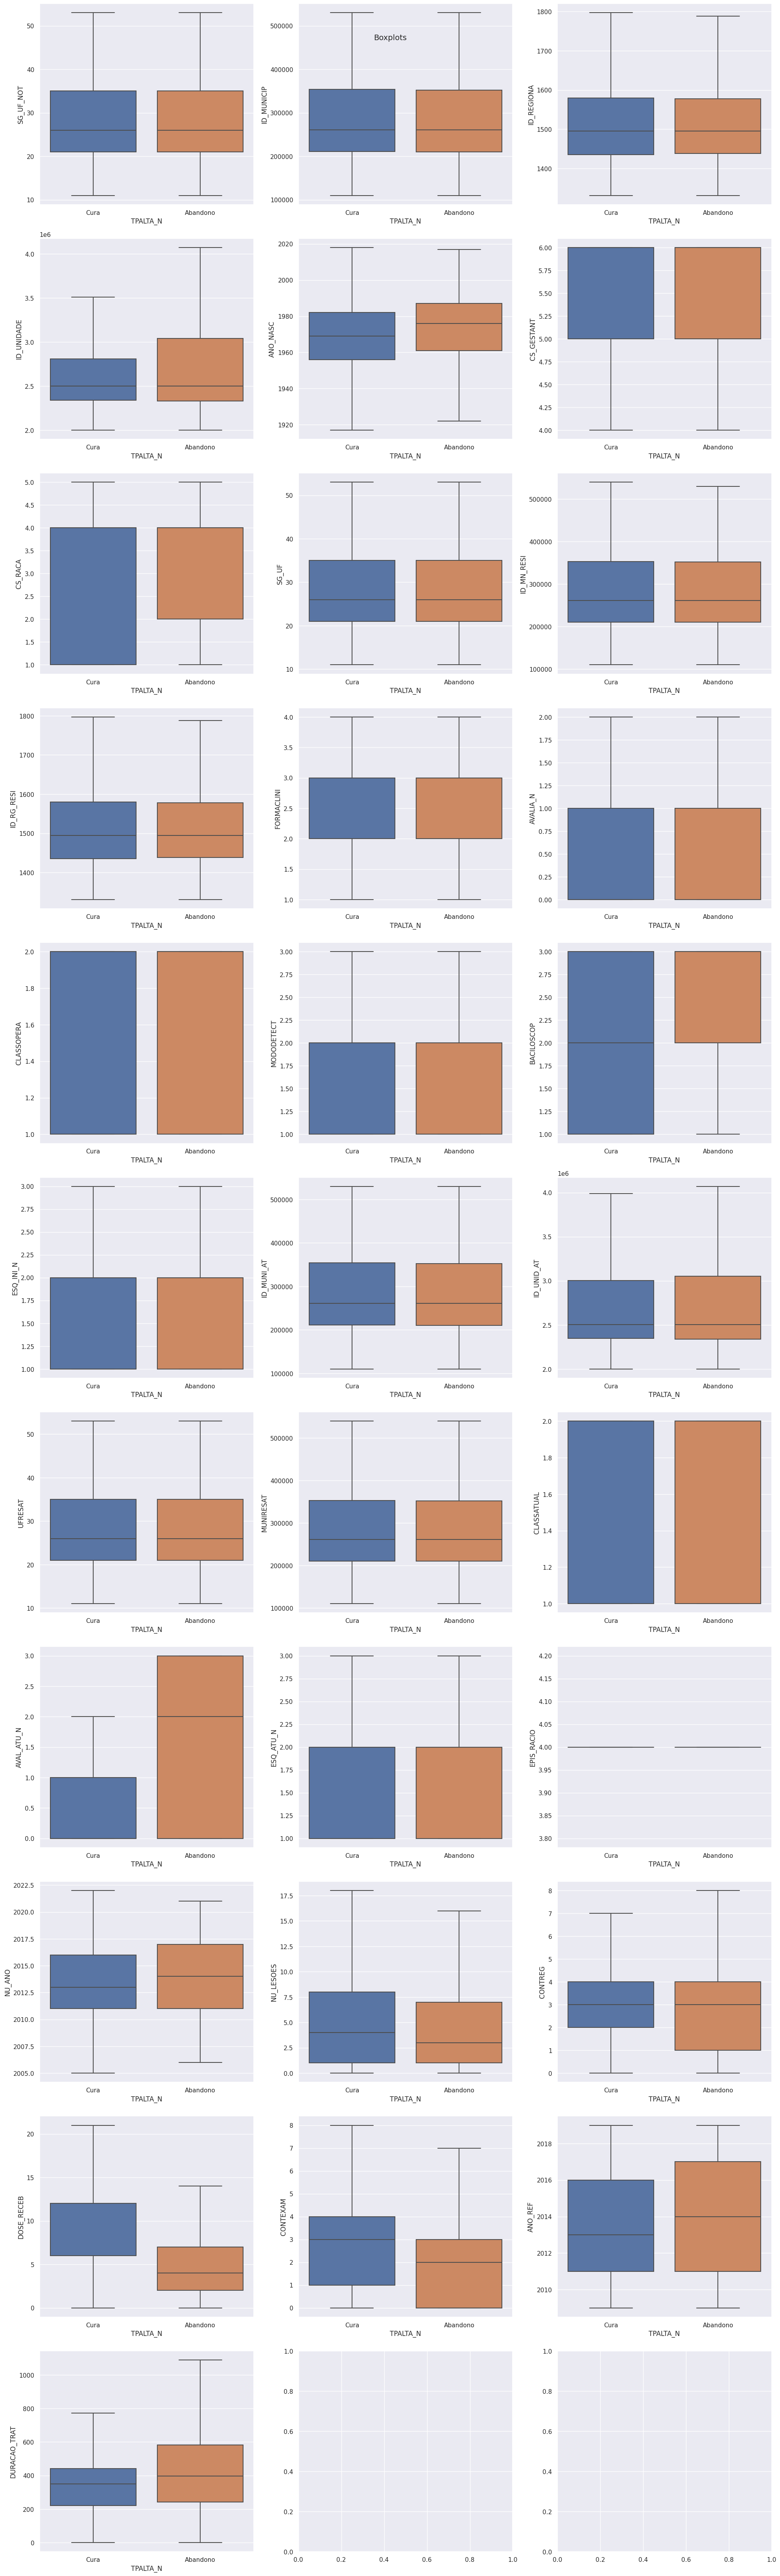

In [41]:
make_subplots(df_hans_outcome, num_feats, target)

In [42]:
num_corr = get_correlations(df_hans_outcome, num_feats, target)
num_corr

,ANOVA_p_value,M.I
DOSE_RECEB,0.000000,0.144805
CLASSATUAL,0.000000,0.049710
ESQ_INI_N,0.000000,0.048948
CLASSOPERA,0.000000,0.048247
CS_RACA,0.000000,0.031658
EPIS_RACIO,0.000000,0.029509
MODODETECT,0.000000,0.026857
CS_GESTANT,0.843918,0.025106
ESQ_ATU_N,0.000000,0.024400
DURACAO_TRAT,0.000000,0.022038


#### Categorical features

In [43]:
cat_feats = [feat for feat in cat_feats if 'DT' not in feat if target not in feat if 'ID' not in feat if 'ESCOL' not in feat]
cat_feats

['CS_SEXO', 'UFATUAL']

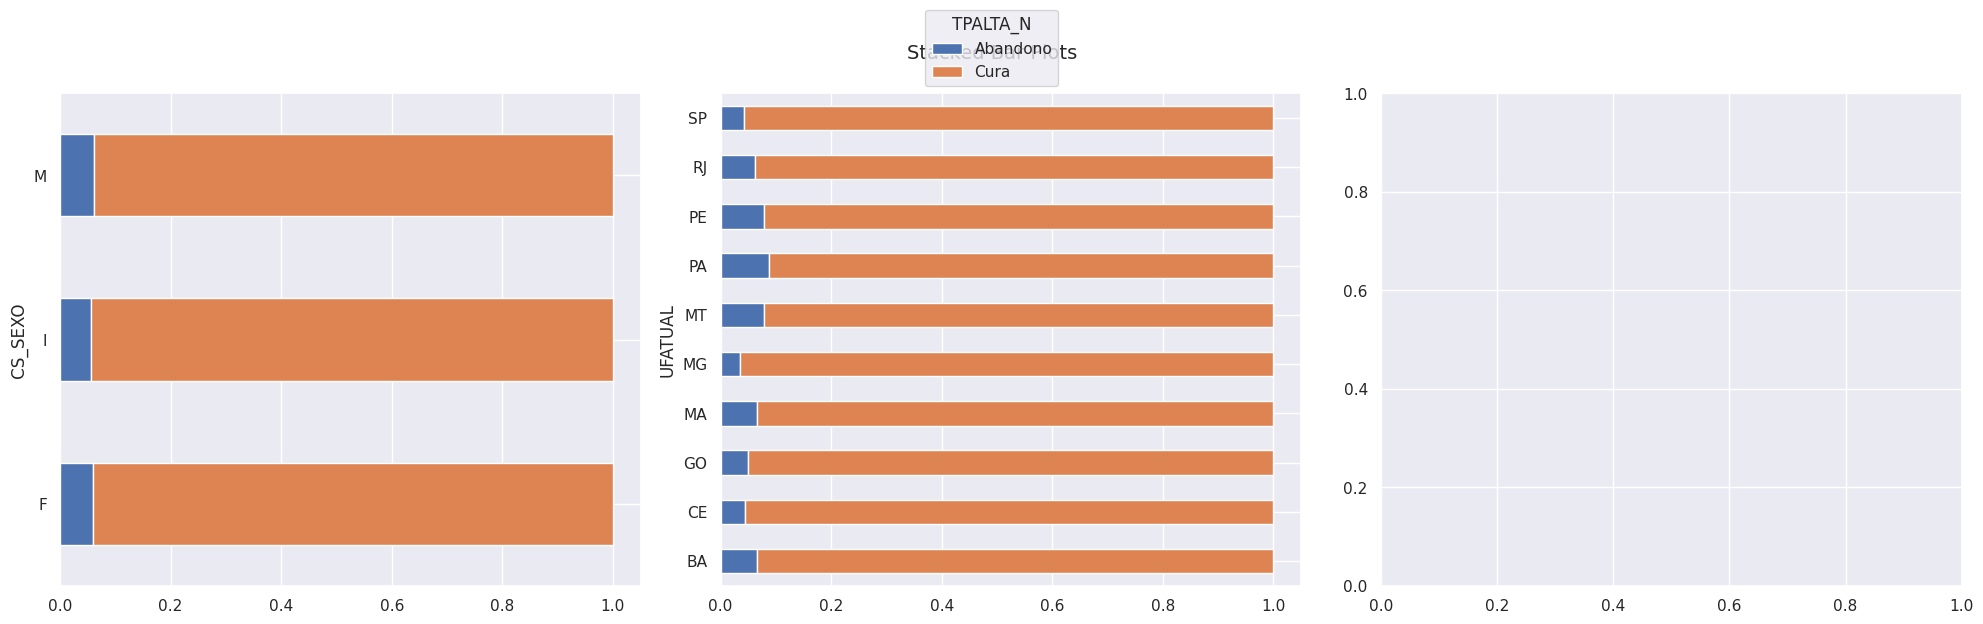

In [44]:
make_subplots(df_hans_outcome, cat_feats, target)

In [45]:
cat_corr = get_correlations(df_hans_outcome, cat_feats, target)
cat_corr

,chi2_p_value,M.I
UFATUAL,0.000000,0.002985
CS_SEXO,0.018853,0.000013


### ML Tests

In [46]:
num_transformer = FeatureUnion(    
    [
        ('num_pipe', Pipeline(
            [
                ('norm', StandardScaler()),
                ('nan_input', SimpleImputer())
            ]
        )),
        ('nan_flag', MissingIndicator(error_on_new=False))
    ]
)
feat_transformer = ColumnTransformer(
    [
        ('num_trans', num_transformer, num_feats),
        ('cat_trans', OneHotEncoder(handle_unknown='ignore'), cat_feats)    
    ],
    remainder='passthrough', sparse_threshold=0
)

In [47]:
X = df_hans_outcome[num_feats + cat_feats].copy()
le = LabelEncoder().fit(df_hans_outcome['TPALTA_N'])
y = le.transform(df_hans_outcome['TPALTA_N'])

#### Random Forest

In [48]:
rf_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', RandomOverSampler()),
                    ('rf', RandomForestClassifier(n_estimators=100))
                   ])

In [49]:
preds = cross_val_predict(rf_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53     18014
           1       0.97      0.97      0.97    276570

    accuracy                           0.94    294584
   macro avg       0.76      0.74      0.75    294584
weighted avg       0.94      0.94      0.94    294584



#### Logistic Regression

In [50]:
lr_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', RandomOverSampler()),
                    ('rf', LogisticRegression(max_iter=100))
                   ])

In [51]:
preds = cross_val_predict(lr_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.37      0.87      0.52     18014
           1       0.99      0.90      0.94    276570

    accuracy                           0.90    294584
   macro avg       0.68      0.89      0.73    294584
weighted avg       0.95      0.90      0.92    294584

